In [34]:
import sqlite3
from pathlib import Path
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts, Compute2DCoordsForReaction
from rdkit.Chem.SimpleEnum.Enumerator import EnumerateReaction
from rdkit import Chem


In [2]:
DATA_DIR = Path('..', 'data').resolve()
DB_PATH = DATA_DIR / 'db' / '50k_project.db'

In [4]:
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

In [19]:
# retrieve on of each buildingblock kind for testing
buildingblocks = cur.execute('SELECT SMILES FROM buildingblocks WHERE long IN (?, ?, ?, ?, ?, ?, ?, ?);', ('Al001', 'Fused002', 'Spiro001', 'Spiro002', 'Mon001', 'Mon072', 'TerABT001', 'TerTH001')).fetchall()
names = ['initiator', 'monomer_fused', 'monomer_spiro_3', 'monomer_spiro_2', 'monomer_sub_3', 'monomer_sub_2', 'ter_abt', 'ter_th']
buildingblocks = [Chem.MolFromSmiles(sm) for tup in buildingblocks for sm in tup]
buildingblocks = {k: v for k, v in zip(names, buildingblocks)}
buildingblocks


{'initiator': <rdkit.Chem.rdchem.Mol at 0x7f9c5637aa00>,
 'monomer_fused': <rdkit.Chem.rdchem.Mol at 0x7f9c5637a220>,
 'monomer_spiro_3': <rdkit.Chem.rdchem.Mol at 0x7f9c5574b580>,
 'monomer_spiro_2': <rdkit.Chem.rdchem.Mol at 0x7f9c5574bc40>,
 'monomer_sub_3': <rdkit.Chem.rdchem.Mol at 0x7f9c5574b400>,
 'monomer_sub_2': <rdkit.Chem.rdchem.Mol at 0x7f9c5644fd60>,
 'ter_abt': <rdkit.Chem.rdchem.Mol at 0x7f9c5646a280>,
 'ter_th': <rdkit.Chem.rdchem.Mol at 0x7f9c5646a2e0>}

In [110]:
# define the reactions

rxn_TH = ReactionFromSmarts(
    'F[B-](F)(F)[#6](-[*:1])=O.O=[#6]1-[#8]C2([#6]-[#6]-[#6]-[#6]-[#6]2)[#8]C11[#6:3]-[#6:2]-[#7]-[#8]1.[#6:4]-[#6](=S)-[#7]-[#7]>>[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)-[#16]-1.[#6:4]-[#6]-1=[#7]-[#7]C([#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)([#16]-1)[#6](-[#8])=O.[#6:4]-[#6]-1=[#7]-[#7+]2=[#6](-[*:1])-[#7]-[#6:2]-[#6:3]C2([#16]-1)[#6](-[#8-])=O.[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[*:1])-[#16]-1.[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#6:4])-[#16]-1.[#8]-[#6](=O)-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#8]-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#6:4]-[#6]-1=[#7]-[#7]=[#6](-[#16]-1)-[#6:3]=[#6:2]'
)

rxn_ABT = ReactionFromSmarts(
    "F[B-](F)(F)[#6](-[*:1])=O.O=[#6]1-[#8]C2([#6]-[#6]-[#6]-[#6]-[#6]2)[#8]C11[#6:3]-[#6:2]-[#7]-[#8]1.[#7]-c1[c:4][c:5][c:6][c:7]c1-[#16]>>[*:1]-[#6](=O)-[#7]-[#6:2]-[#6:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1.[#8]-[#6](=O)C1([#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O)[#7]-c2[c:4][c:5][c:6][c:7]c2-[#16]1.[#8-]-[#6](=O)C12[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=[#7+]1-c1[c:4][c:5][c:6][c:7]c1-[#16]2.[*:1]-c1nc2[c:4][c:5][c:6][c:7]c2s1.[#7]-c1[c:4][c:5][c:6][c:7]c1-[#16]-[#16]-c1[c:7][c:6][c:5][c:4]c1-[#7].[#8]-[#6](=O)-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#8]-[#6](=O)-[#6:3]-[#6:2]-[#7]-[#6](-[*:1])=O.[#6:2]=[#6;v4:3]-c1nc2[c:4][c:5][c:6][c:7]c2s1"
)
# prepare for visualization
Compute2DCoordsForReaction(rxn_TH)
Compute2DCoordsForReaction(rxn_ABT)
# prepare for enumeration
rxn_TH.Initialize()
rxn_ABT.Initialize()

RDKit WARNING: ple times.
RDKit WARNING: [14:47:20] product atom-mapping number 2 found multiple times.
RDKit WARNING: [14:47:20] product atom-mapping number 3 found multiple times.
RDKit WARNING: [14:47:20] product atom-mapping number 4 found multiple times.
RDKit WARNING: [14:47:20] product atom-mapping number 5 found multiple times.
RDKit WARNING: [14:47:20] product atom-mapping number 6 found multiple times.
RDKit WARNING: [14:47:20] product atom-mapping number 7 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 4 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 3 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 2 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 1 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 4 found multiple times.
RDKit WARNING: [15:37:50] product atom-mapping number 1 found multiple times.
RDKit WARNING: [15:37:50] product atom

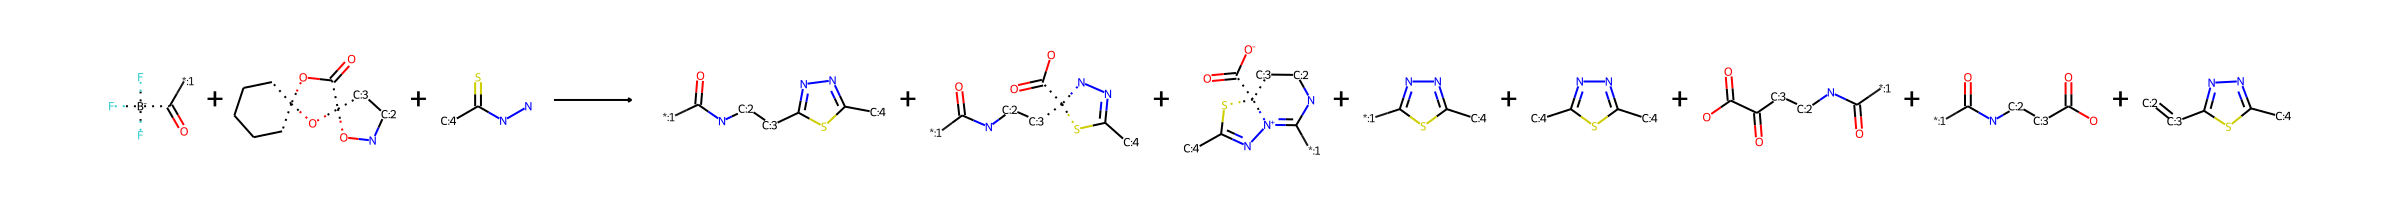

In [111]:
# Control reactions visually
Draw.ReactionToImage(rxn_TH)

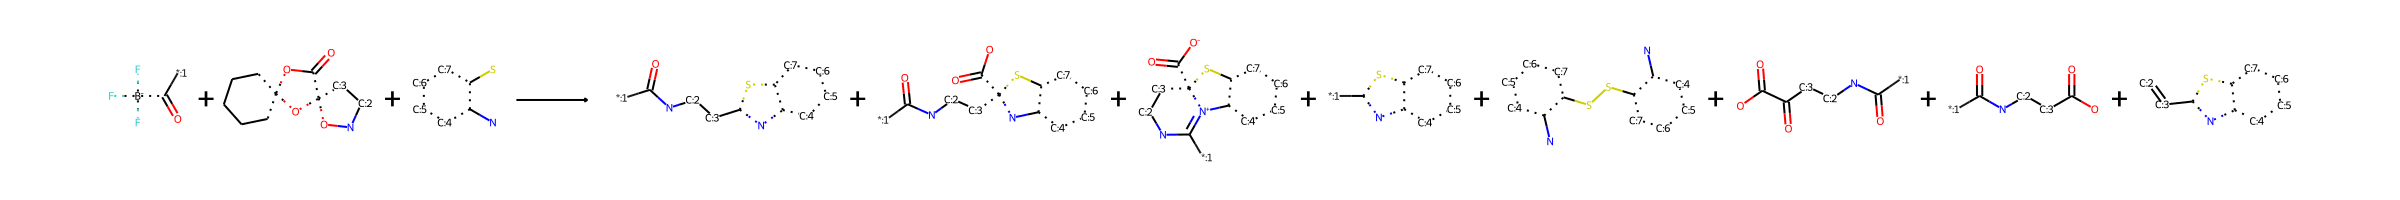

In [59]:
# Control reactions visually
Draw.ReactionToImage(rxn_ABT)

In [112]:
# Control which reactants work
print('Reactants working in the TH reaction:')
for k, v in buildingblocks.items():
    print(f'{k}: {rxn_TH.IsMoleculeReactant(v)}')

Reactants working in the TH reaction:
initiator: True
monomer_fused: True
monomer_spiro_3: True
monomer_spiro_2: True
monomer_sub_3: True
monomer_sub_2: True
ter_abt: False
ter_th: True


In [32]:
# Control which reactants work
print('Reactants working in the ABT reaction:')
for k, v in buildingblocks.items():
    print(f'{k}: {rxn_ABT.IsMoleculeReactant(v)}')

Reactants working in the ABT reaction:
initiator: True
monomer_fused: True
monomer_spiro_3: True
monomer_spiro_2: True
monomer_sub_3: True
monomer_sub_2: True
ter_abt: True
ter_th: False


In [173]:
# Perform enumeration
product_generator_TH = EnumerateReaction(rxn_TH, ([buildingblocks['initiator']], [buildingblocks['monomer_fused'], buildingblocks['monomer_spiro_3'], buildingblocks['monomer_spiro_2'], buildingblocks['monomer_sub_3'], buildingblocks['monomer_sub_2']], [buildingblocks['ter_th']]), uniqueProductsOnly=True)
product_generator_ABT = EnumerateReaction(rxn_ABT, ([buildingblocks['initiator']], [buildingblocks['monomer_fused'], buildingblocks['monomer_spiro_3'], buildingblocks['monomer_spiro_2'], buildingblocks['monomer_sub_3'], buildingblocks['monomer_sub_2']], [buildingblocks['ter_abt']]), uniqueProductsOnly=True)

RDKit WARNING: 15:56:30] product atom-mapping number 2 found multiple times.
RDKit WARNING: [15:56:30] product atom-mapping number 3 found multiple times.
RDKit WARNING: [15:56:30] product atom-mapping number 4 found multiple times.
RDKit WARNING: [15:56:30] product atom-mapping number 5 found multiple times.
RDKit WARNING: [15:56:30] product atom-mapping number 6 found multiple times.
RDKit WARNING: [15:56:30] product atom-mapping number 7 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 4 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 3 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 2 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 1 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 4 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 1 found multiple times.
RDKit WARNING: [15:57:54] product atom-mapping number 2 found mul

In [174]:
product_list_TH = list(product_generator_TH)
product_list_ABT = list(product_generator_ABT)

In [175]:
for ps in product_list_ABT:
    mol = ps[7]
    problems = Chem.DetectChemistryProblems(mol)
    print(problems)
    if len(problems) > 0:
        if problems[0].GetType() == 'AtomValenceException':
            try:
                atom_idx = problems[0].GetAtomIdx()
                mol.GetAtomWithIdx(atom_idx).SetNumExplicitHs(0)
            except ValueError:
                print('fail')
                pass

for reac in product_list_ABT:
    for prod in reac:
        try:
            Chem.SanitizeMol(prod)
        except:
            print('no')

(<rdkit.Chem.rdchem._cppAtomValenceException object at 0x7f9c55e4acf0>,)
()
(<rdkit.Chem.rdchem._cppAtomValenceException object at 0x7f9c55e4acf0>,)
()
(<rdkit.Chem.rdchem._cppAtomValenceException object at 0x7f9c55e4acf0>,)
no


RDKit ERROR: [15[15:57:56] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:57:56] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:57:56] Explicit valence for atom # 1 C, 5, is greater than permitted
RDKit ERROR: [15:57:56] Explicit valence for atom # 1 C, 5, is greater than permitted


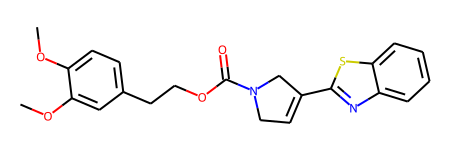

In [176]:
product_list_ABT[0][7]

In [107]:
for atom in product_list_TH[0][0].GetAtoms():
   print(atom.GetSymbol(), atom.GetTotalValence(), atom.GetExplicitValence(), atom.GetImplicitValence(), atom.GetNumExplicitHs(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(), atom.NeedsUpdatePropertyCache())

C 4 4 0 0 0 0 False
C 4 4 0 0 0 0 False
N 3 3 0 0 0 0 False
N 3 3 0 0 0 0 False
C 4 4 0 0 0 0 False
S 2 2 0 0 0 0 False
C 3 3 0 1 0 1 False
C 4 2 2 0 2 2 False
C 4 2 2 0 2 2 False
N 3 3 0 0 0 0 False
C 4 4 0 0 0 0 False
C 4 2 2 0 2 2 False
O 2 2 0 0 0 0 False
O 2 2 0 0 0 0 False
C 4 2 2 0 2 2 False
C 4 2 2 0 2 2 False
C 4 4 0 0 0 0 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False
C 4 4 0 0 0 0 False
C 4 4 0 0 0 0 False
O 2 2 0 0 0 0 False
O 2 2 0 0 0 0 False
C 4 1 3 0 3 3 False
C 4 1 3 0 3 3 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False
C 4 3 1 0 1 1 False


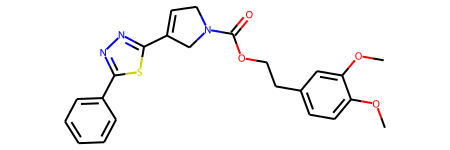

In [82]:
# this works but better get the reaction right
product_list_TH[0][7].GetAtomWithIdx(6).SetNumExplicitHs(0)
product_list_TH[0][7]